  # CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

In [1]:
# If this cell does not work try running ``

import io
import nbformat

nb = nbformat.read("Lab1.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 992


In [2]:
py_version = !python --version
print(py_version[0])
print("+++++++++++++")
import sklearn
print("scikit-learn", sklearn.__version__)
import pandas
print("pandas", pandas.__version__)
import seaborn
print("seaborn", seaborn.__version__)
import matplotlib
print("matplotlib", matplotlib.__version__)
import imblearn
print("imbalanced-learn", imblearn.__version__)
import plotly
print("plotly", plotly.__version__)
import nbformat
print("nbformat", nbformat.__version__)
import statsmodels
print("statsmodels", statsmodels.__version__)

Python 3.11.2
+++++++++++++
scikit-learn 1.2.2
pandas 1.5.3
seaborn 0.12.2
matplotlib 3.7.1
imbalanced-learn 0.10.1
plotly 5.14.1
nbformat 5.8.0
statsmodels 0.14.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import tensorflow_data_validation as tfdv

In [4]:
def col(rgb, text):
    r, g, b = rgb
    return f"\033[38;2;{r};{g};{b}m{text} \033[0m"
print(col((255, 0, 0), "Test"))

Test 


## 1. Visualization task – 1 A4

## Train and Test data

Firstly, it is vital to understand how the Train and Test datasets differ. We start by examining the basic statistics of both datasets, such as the mean, standard deviation, minimum, and maximum values for each feature. We can also visualize the distribution of each feature in both datasets using heat maps, box plots, bar charts and density plots.

In [157]:
# Load the data inside pandas Dataframe
import os

train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

# Connect the train and test dataframes
train_data_df['is_train'] = 1
test_data_df['is_train'] = 0
data_df = pd.concat([train_data_df, test_data_df], axis=0, sort=False)

# check the number of card ids that exist in both train and test data
print("Number of card ids that exist in both train and test data: ", len(set(train_data_df['card_id'].unique()).intersection(set(test_data_df['card_id'].unique()))))
print("Unique card ids", len(train_data_df['card_id'].unique()))
print("Duplicate card ids", len(train_data_df['card_id']) - len(train_data_df['card_id'].unique()))

train_data_df['label'].sum()

Number of card ids that exist in both train and test data:  6797
Unique card ids 171763
Duplicate card ids 17865


276

In [6]:
train_data_df.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,is_train
Id,,,,,,,,,,,,,,,
1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0,1
2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0,1
3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0,1
4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0,1
6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0,1


In [7]:
test_data_df.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,is_train
Id,,,,,,,,,,,,,,
0,GB,visadebit,492181.0,1095.0,GBP,GB,Ecommerce,NaN,1,UKAccount,email327589,ip144935,card115008,0
5,GB,mcdebit,557379.0,5400.0,GBP,GB,Ecommerce,True,1,UKAccount,email273226,ip12784,card20633,0
7,GB,visaplatinum,492913.0,17510.0,GBP,GB,Ecommerce,True,1,UKAccount,email67749,ip194560,card130375,0
9,NZ,visadebit,494310.0,15000.0,NZD,NZ,Ecommerce,True,0,APACAccount,email55458,ip130239,card195989,0
16,AU,mccredit,518868.0,11050.0,AUD,AU,Ecommerce,True,0,APACAccount,email190209,ip31190,card155450,0


### Fruad by Currency

The bar chart shows that for a given currency, what is the chance that the transaction will be fraudulent. It shows that transactions with Mexican Pesos (MXN) have the highest chance to be used in a fraudulent transaction. Albeit, it is still very small percentage of 1.59%. Others have less or equal change of 0.5%.

In [8]:
def autolabel(rects, axies):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axies.text(rect.get_x() + rect.get_width()/2., 1.*height, f'{height:.4f}', ha='center', va='bottom')

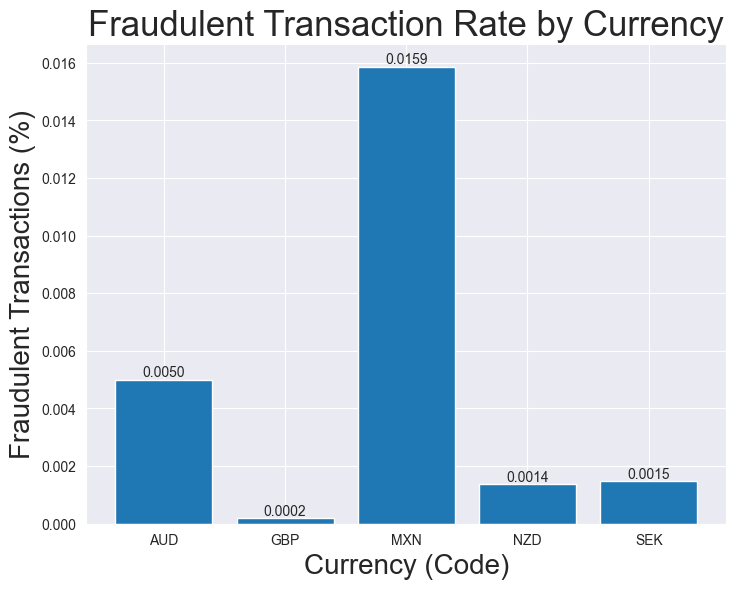

In [9]:
# Group by currency type and plot the mean of the label
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
mean_fraud = train_data_df.groupby('currencycode')['label'].mean()
bars_rects = ax.bar(mean_fraud.index, mean_fraud.values)
ax.set_ylabel('Fraudulent Transactions (%)', fontsize=20)
ax.set_xlabel('Currency (Code)', fontsize=20)
ax.set_title('Fraudulent Transaction Rate by Currency', fontsize=25)
autolabel(bars_rects, ax)
plt.show()

### **Fraud by Shoppers Origin**

The bar chart shows that for a given shopper's country of origin, what is the chance that the transaction will be fraudulent. It shows that transactions from Brazil have the highest chance of being fraudulent with 6.67% chance. Out of 136 countries, only 12 countries had fraudulent transactions.

<Figure size 10000x2000 with 0 Axes>

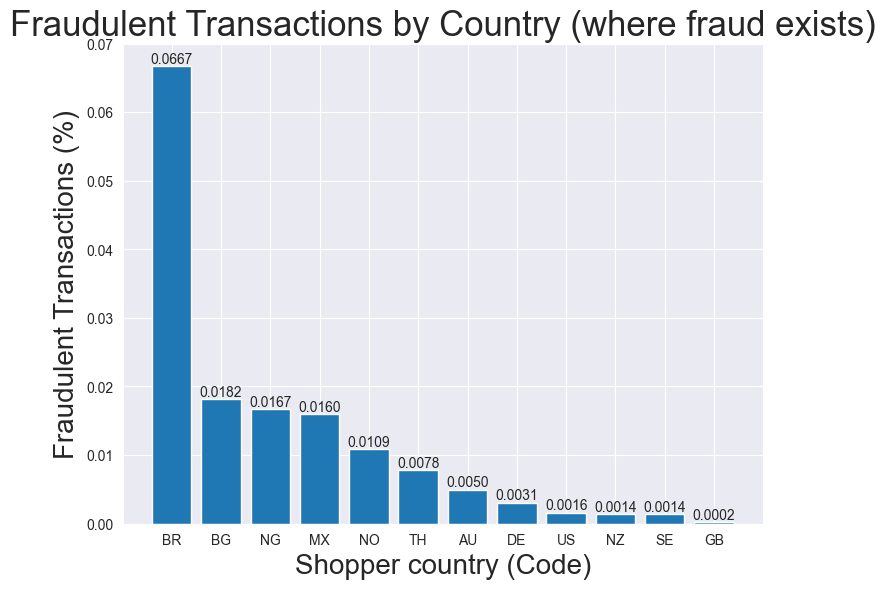

In [10]:
plt.figure(figsize=(100, 20))
fraudulent_mean_data = train_data_df.groupby('shoppercountrycode')['label'].mean()
fraudulent_mean_data = pd.DataFrame(fraudulent_mean_data).reset_index()
fraudulent_mean_data = fraudulent_mean_data[fraudulent_mean_data['label'] > 0.0]
fraudulent_mean_data = fraudulent_mean_data.sort_values(ascending=False, by='label')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
contries = fraudulent_mean_data['shoppercountrycode'].to_list()
mean_fraud = fraudulent_mean_data['label'].to_list()
bars_rects = ax.bar(contries,mean_fraud)
ax.set_ylabel('Fraudulent Transactions (%)', fontsize=20)
ax.set_xlabel('Shopper country (Code)', fontsize=20)
ax.set_title('Fraudulent Transactions by Country (where fraud exists)', fontsize=25)
autolabel(bars_rects, ax)
plt.show()

#### **Amount of money for transactions**

Here the amount of money for a transaction is investigated against the fraudulence label. To do that, Histogram and Box Plot were used. Before that, since the money is in different currencies, we decided to convert them to Euro by using Python's pip package `currency_converter` and used the 02/01/2023 day for the conversion rates. From both graphs we can see that valid transations have much more variety in amount with more outliers of large amounts while fradulent transactions seem to be in a smaller range but higher median than valid transactions.

In [11]:
!pip install currencyconverter


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from datetime import date # datetime works too
from currency_converter import CurrencyConverter
c = CurrencyConverter()

def conv(row, data_conv=date(2023, 1, 2)):
    return c.convert(row['amount'], row['currencycode'], 'EUR', date=data_conv)

converted_train_df = train_data_df.copy(deep=True)
converted_train_df['amount_eur'] = converted_train_df.apply(lambda x: conv(x), axis=1)
converted_train_df.head()

,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,is_train,amount_eur
Id,,,,,,,,,,,,,,,,
1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0,1,5077.287600
2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0,1,3830.531423
3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0,1,4394.674489
4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0,1,17313.550716
6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0,1,5748.617849


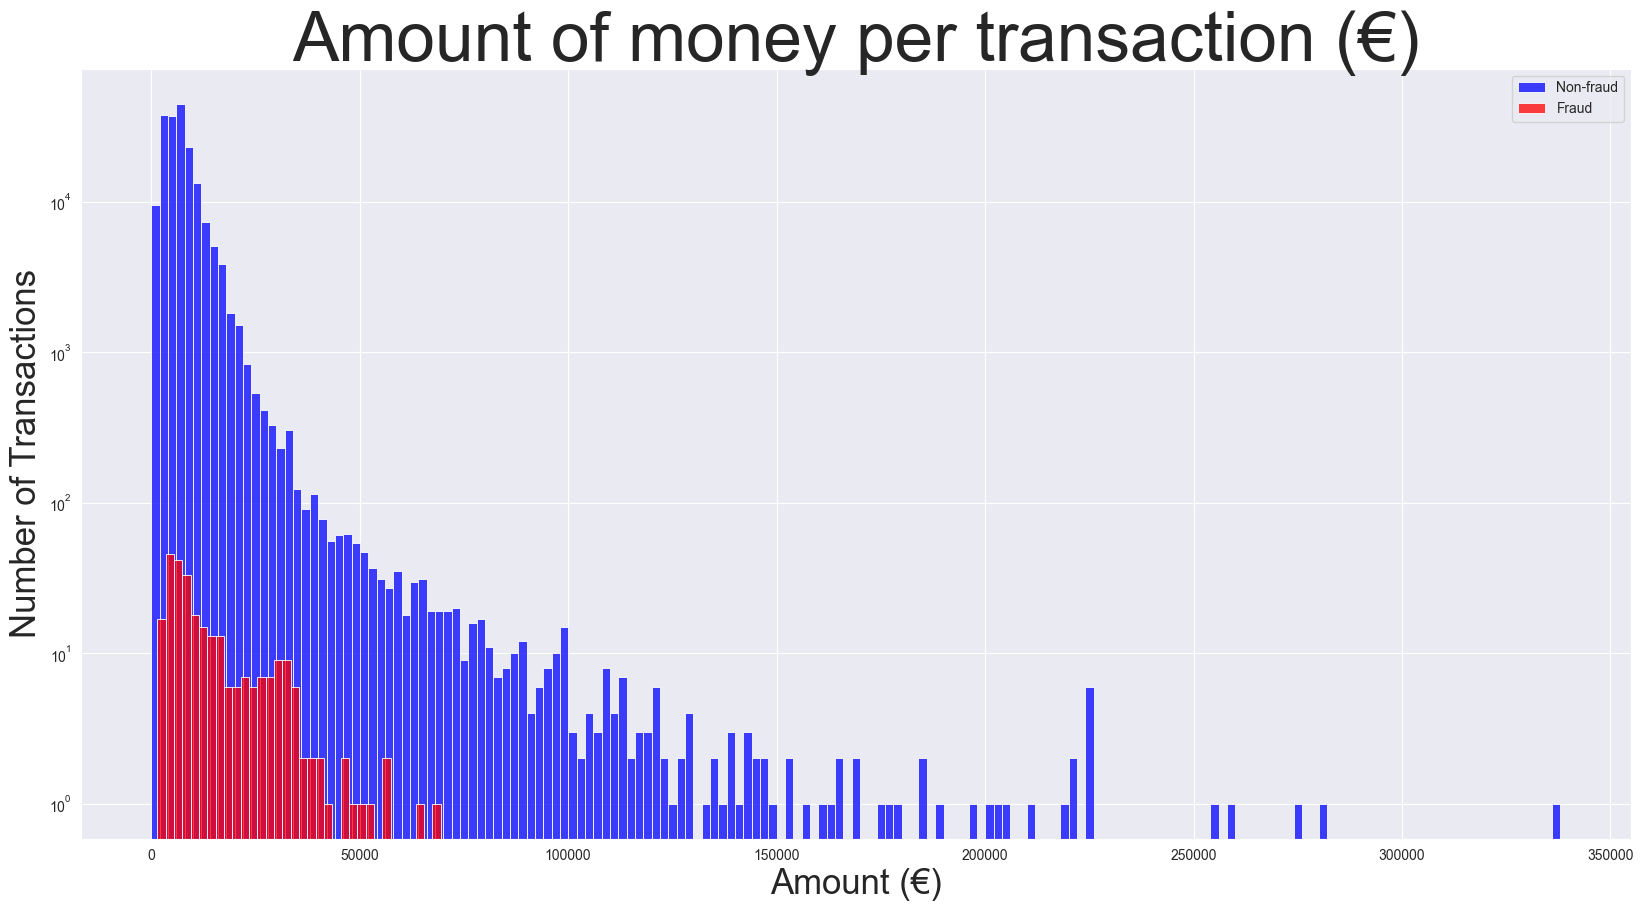

In [13]:
# Plot the distribution of the amount depending on the label
df_amount_fraud = converted_train_df[converted_train_df['label'] == 1]['amount_eur']
df_amount_non_fraud = converted_train_df[converted_train_df['label'] == 0]['amount_eur']
plt.figure(figsize=(20, 10))
sns.histplot(df_amount_non_fraud, color='blue', label='Non-fraud', log_scale=(False, True), binwidth=2000)
sns.histplot(df_amount_fraud, color='red', label='Fraud', log_scale=(False, True), binwidth=2000)
plt.title('Amount of money per transaction (€)', fontsize=50)
plt.ylabel('Number of Transactions', fontsize=25)
plt.xlabel('Amount (€)', fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.show()

In [14]:
df_amount_fraud.max()

68912.71056661563

In [15]:
df_amount_fraud.min()

1435.3056384949932

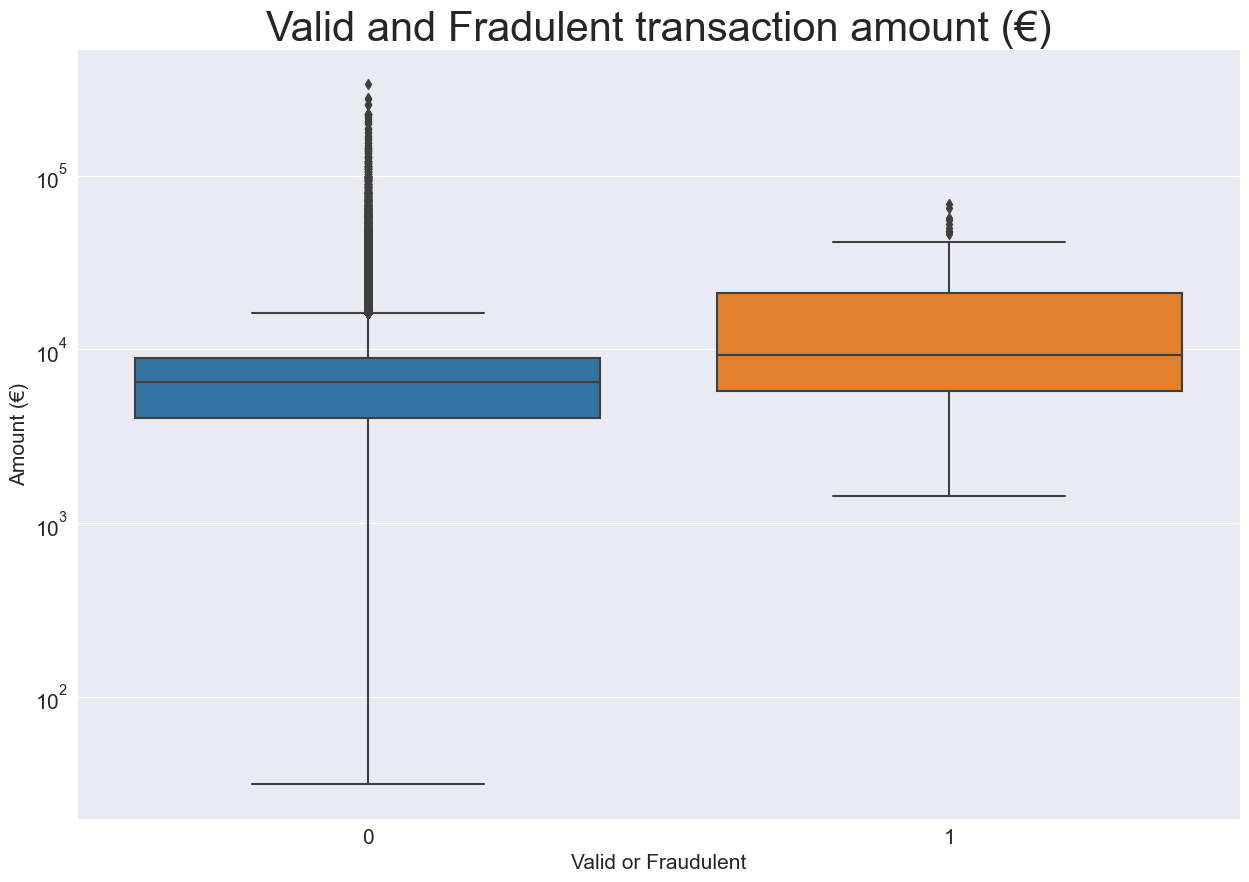

In [16]:
# Create a boxplot of the log of amount depending on the label converted_train_df['amount_eur']
plt.figure(figsize=(15, 10))
sns.boxplot(x='label', y=converted_train_df['amount_eur'], data=converted_train_df)
plt.title('Valid and Fradulent transaction amount (€)', fontsize=30)
plt.ylabel('Amount (€)', fontsize=15)
plt.xlabel("Valid or Fraudulent", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.show()

### **Correlation between shopper's country of origin and issuer country**

From the bar charts below we can see that a difference between shopper's country of origin and issuer country has a very negledgable increase of fraudulence. 

In [17]:
buyer_with_same_issuer_df = train_data_df[train_data_df['issuercountrycode'] == train_data_df['shoppercountrycode']]
buyer_with_diff_issuer_df = train_data_df[train_data_df['issuercountrycode'] != train_data_df['shoppercountrycode']]

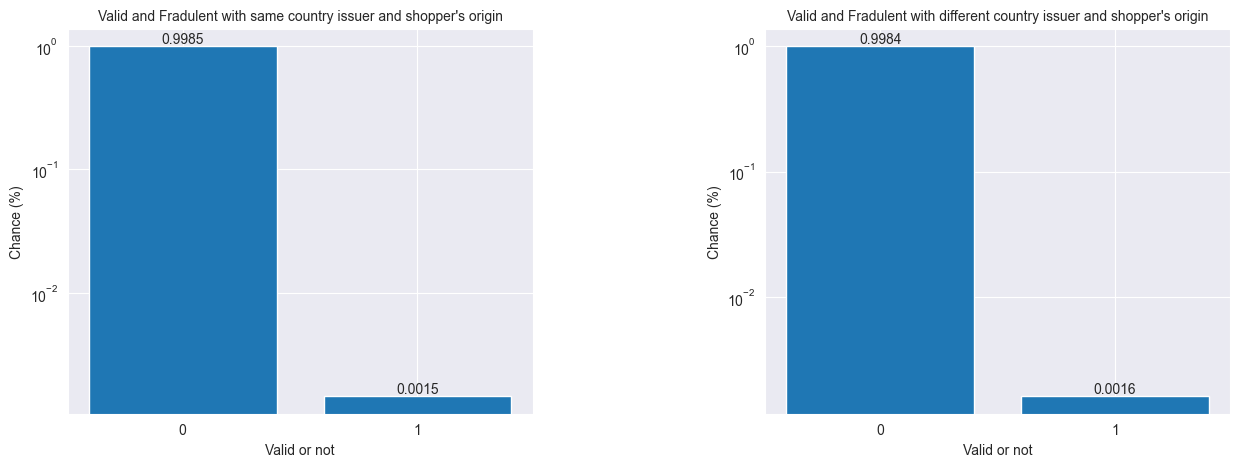

In [18]:
same_code_sr = buyer_with_same_issuer_df["label"].value_counts(normalize=True)
diff_code_sr = buyer_with_diff_issuer_df["label"].value_counts(normalize=True)

fig, (ax1, ax2) = plt.subplots(1,2,figsize =(15, 5))
fig.subplots_adjust(wspace=0.5)

fraud_or_not = same_code_sr.index
percentage_chance = same_code_sr.values
bars_rects = ax1.bar(fraud_or_not, percentage_chance)
ax1.set_ylabel('Chance (%)', fontsize=10)
ax1.set_xlabel("Valid or not", fontsize=10)
ax1.set_title("Valid and Fradulent with same country issuer and shopper's origin", fontsize=10)

autolabel(bars_rects, ax1)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(min(fraud_or_not), max(fraud_or_not)+1, 1.0))


fraud_or_not = diff_code_sr.index
percentage_chance = diff_code_sr.values
bars_rects = ax2.bar(fraud_or_not, percentage_chance)
ax2.set_ylabel('Chance (%)', fontsize=10)
ax2.set_xlabel("Valid or not", fontsize=10)
ax2.set_title("Valid and Fradulent with different country issuer and shopper's origin", fontsize=10)

autolabel(bars_rects, ax2)
ax2.set_xticks(np.arange(min(fraud_or_not), max(fraud_or_not)+1, 1.0))
ax2.set_yscale('log')
plt.show()

## Data preprocessing pipeline

Before we can train our models, we need to preprocess the data first. For this, we have implemented a `CustomDataTransformer` that inherits from the `sklearn`'s classes (`BaseEstimator`, `TransformerMixin`) so that it can be fed into a `sklearn` pipeline.
The pipeline provides a structured, reproducible, and efficient approach to preparing data for machine learning models. It promotes code organization, simplifies integration with model training, and enhances compatibility with other sklearn data processing components (e.g. Normalizer, Standard Scalar, PCA and etc.), leading to more efficient and effective machine learning workflows. These pipelines run `fit_transform(X)` function which 'learns' the data featues and transforms them to the learned format.

Example pipelines can be seen below.

In [19]:
# import re
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import LabelEncoder
# from sklearn.base import TransformerMixin, BaseEstimator
#
#
# def country_equal_feature_eng(df):
#     # Check if the shopper's country of origin is the same as the issuer country
#     df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
#     df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
#     df.loc[df['countries_equal'] == True, 'countries_equal'] = 1
#
#     return df
#
#
# class CustomDataTransformer(BaseEstimator, TransformerMixin):
#
#     def __init__(
#         self, currency_conv_func,
#         feature_engineering_func=country_equal_feature_eng,
#         card_enc=LabelEncoder(),
#         ip_enc=LabelEncoder(),
#         country_code_enc=LabelEncoder(),
#         tx_variant_code_enc=LabelEncoder(),
#         currency_code_enc=LabelEncoder(),
#         shopper_interaction_enc=LabelEncoder(),
#         account_code_enc=LabelEncoder(),
#         card_verif_code_supplied=LabelEncoder(),
#         mail_id_enc=LabelEncoder(),
#         bin_encoder=LabelEncoder(),
#         scaler=StandardScaler(),
#
#         drop_private_columns=False,
#         columns_to_scale=None,
#         one_hot_columns=None
#
#     ):
#         '''
#
#         :param currency_conv_func: currency conversion function
#         :param feature_engineering_func: feature engineering function
#         :param card_enc: card encoder
#         :param ip_enc: ip encoder
#         :param country_code_enc:  country code encoder
#         :param tx_variant_code_enc: tx variant code encoder
#         :param currency_code_enc:  currency code encoder
#         :param shopper_interaction_enc:  shopper interaction encoder
#         :param account_code_enc: account code encoder
#         :param card_verif_code_supplied: card verification code supplied encoder
#         :param mail_id_enc: mail id encoder
#         :param scaler: scaler used
#         :param drop_private_columns: drop columns that might be considered sensitive data (e.g. mail_id)
#         :param columns_to_scale: columns that will be scaled using the scaler
#         :param one_hot_columns: columns that will be one-hot encoded
#         '''
#         self.card_enc = card_enc
#         self.ip_enc = ip_enc
#         self.country_code_enc = country_code_enc
#         self.tx_variant_code_enc = tx_variant_code_enc
#         self.currency_code_enc = currency_code_enc
#         self.shopper_interaction_enc = shopper_interaction_enc
#         self.account_code_enc = account_code_enc
#         self.bin_enc = bin_encoder
#         self.card_verif_code_supplied = card_verif_code_supplied
#         self.mail_id_enc = mail_id_enc
#
#         self.currency_conv_func = currency_conv_func
#         self.feature_eng_func = feature_engineering_func
#
#         self.country_codes = None
#         self.cleaned_data = None
#
#         self.scaler = scaler
#         if columns_to_scale is None:
#             self.columns_to_scale = []
#         else:
#             self.columns_to_scale = columns_to_scale
#         if one_hot_columns is None:
#             self.one_hot_columns = []
#         else:
#             self.one_hot_columns = one_hot_columns
#
#         self.drop_private_columns = drop_private_columns
#
#     def _clean_data(self, df):
#         # Cleaning up data inconsisstencies
#         df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
#         # df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
#         df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3
#
#         df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = '--'
#         df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = '--'
#         unique_issuer_cc = df['issuercountrycode'].unique()
#         unique_shopper_cc = df['shoppercountrycode'].unique()
#         both = np.append(unique_issuer_cc, unique_shopper_cc)
#         df_countrycodes = pd.DataFrame(both)
#         unique_country_codes = df_countrycodes[0].unique()
#         self.country_codes = unique_country_codes
#
#         df['amount_eur'] = df.apply(lambda x: self.currency_conv_func(x), axis=1)
#         df.drop("amount", axis=1, inplace=True)
#         df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
#         df.loc[(df['accountcode'] == 'UK'),'accountcode'] = 'GB'
#         df.loc[(df['accountcode'] == 'Mexico'),'accountcode'] = 'MX'
#         df.loc[(df['accountcode'] == 'Sweden'),'accountcode'] = 'SE'
#         df.loc[(df['accountcode'] == 'APAC'),'accountcode'] = 'APAC'
#
#
#         return df
#
#     def fit(self, X, y=None):
#         df = X.copy(deep=True)
#         df = self._clean_data(df)
#
#         # 1.Card ID
#         self.card_enc.fit(df['card_id'])
#
#
#         # 2.IP ID
#         self.ip_enc.fit(df['ip_id'])
#
#         # 3. Country code
#         self.country_code_enc.fit(self.country_codes)
#
#         # 4. TX variant code
#         self.tx_variant_code_enc.fit(df['txvariantcode'])
#
#         # 5. Currency code
#         self.currency_code_enc.fit(df['currencycode'])
#
#         # 6. Shopper Interaction
#         self.shopper_interaction_enc.fit(df['shopperinteraction'])
#
#         # 7. Account code
#         self.account_code_enc.fit(df['accountcode'])
#         # df['accountcode'] = self.account_code_enc.transform(df.accountcode)
#
#         # 8. Card Verification Code Supplied
#         self.card_verif_code_supplied.fit(df['cardverificationcodesupplied'])
#         # df['cardverificationcodesupplied'] = self.card_verif_code_supplied.transform(
#         #     df.cardverificationcodesupplied
#         # )
#
#         # 9. Email ID
#         self.mail_id_enc.fit(df['mail_id'])
#
#         # 10. Bin
#         self.bin_enc.fit(df['bin'])
#         # df['mail_id'] = self.mail_id_enc.transform(df.mail_id)
#         # df.drop("mail_id", axis=1, inplace=True)
#         #
#         # # Fit the scaler
#         # if self.scaler is not None:
#         #     self.scaler.fit(df)
#
#         return self
#
#     def transform(self, X):
#         df = X.copy(deep=True)
#         df = self._clean_data(df)
#
#         # Feature Engineering
#         if self.feature_eng_func is not None:
#             df = self.feature_eng_func(df)
#
#         # 1.Card ID
#         if self.drop_private_columns:
#             df.drop("card_id", axis=1, inplace=True)
#         else:
#             df['card_id'] = self.card_enc.transform(df.card_id)
#
#         # 2.IP ID
#         # df['ip_id'] = self.ip_enc.transform(df.ip_id)
#         if self.drop_private_columns:
#             df.drop("ip_id", axis=1, inplace=True)
#         else:
#             df['ip_id'] = self.ip_enc.transform(df.ip_id)
#         # 3. Country code
#         if 'issuercountrycode' not in self.one_hot_columns:
#             df['issuercountrycode'] = self.country_code_enc.transform(df.issuercountrycode)
#         if 'shoppercountrycode' not in self.one_hot_columns:
#             df['shoppercountrycode'] = self.country_code_enc.transform(df.shoppercountrycode)
#
#         # 4. TX variant code
#         if 'txvariantcode' not in self.one_hot_columns:
#             df['txvariantcode'] = self.tx_variant_code_enc.transform(df.txvariantcode)
#
#         # 5. Currency code
#         if 'currencycode' not in self.one_hot_columns:
#             df['currencycode'] = self.currency_code_enc.transform(df.currencycode)
#
#         # 6. Shopper Interaction
#         if 'shopperinteraction' not in self.one_hot_columns:
#             df['shopperinteraction'] = self.shopper_interaction_enc.transform(
#                 df.shopperinteraction
#             )
#
#         # 7. Account code
#         if 'accountcode' not in self.one_hot_columns:
#             df['accountcode'] = self.account_code_enc.transform(df.accountcode)
#
#         # 8. Card Verification Code Supplied
#         if 'cardverificationcodesupplied' not in self.one_hot_columns:
#             df['cardverificationcodesupplied'] = self.card_verif_code_supplied.transform(df['cardverificationcodesupplied'])
#
#         # 9. Email ID
#         if self.drop_private_columns:
#             df.drop("mail_id", axis=1, inplace=True)
#         else:
#             df['mail_id'] = self.mail_id_enc.transform(df.mail_id)
#
#         # 10. Bin
#         if self.drop_private_columns:
#             df.drop("bin", axis=1, inplace=True)
#         else:
#             df['bin'] = self.bin_enc.transform(df.bin)
#         # df.drop("bin", axis=1, inplace=True)
#
#         # Scale the data
#         if self.scaler is not None and len(self.columns_to_scale) > 0:
#             # Columns to scale
#             scale_columns = np.array(df[self.columns_to_scale])
#             if len(scale_columns.shape) == 1:
#                 scale_columns = scale_columns.reshape(-1, 1)
#                 df[self.columns_to_scale] = self.scaler.fit_transform(scale_columns).reshape(-1)
#             df[self.columns_to_scale] = self.scaler.fit_transform(scale_columns)
#
#         if len(self.one_hot_columns) > 0:
#             df = self.one_hot_encode(df)
#         return df
#
#     def one_hot_encode(self, df):
#         # One hot encode the selected columns
#         cols_to_encode = df[self.one_hot_columns]
#         encoder = OneHotEncoder(sparse=False)
#         encoded_cols = encoder.fit_transform(cols_to_encode)
#         encoded_cols_df = pd.DataFrame(
#             encoded_cols, columns=encoder.get_feature_names(self.one_hot_columns), index=df.index
#         )
#         df.drop(self.one_hot_columns, axis=1, inplace=True)
#         df = pd.concat([df, encoded_cols_df], axis=1)
#
#         return df


In [113]:
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin, BaseEstimator


def country_equal_feature_eng(df):
    # Check if the shopper's country of origin is the same as the issuer country
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    return df


class CustomDataTransformer(BaseEstimator, TransformerMixin):

    def __init__(
        self, currency_conv_func,
        feature_engineering_func=country_equal_feature_eng,
        card_enc=LabelEncoder(),
        ip_enc=LabelEncoder(),
        country_code_enc=LabelEncoder(),
        tx_variant_code_enc=LabelEncoder(),
        currency_code_enc=LabelEncoder(),
        shopper_interaction_enc=LabelEncoder(),
        account_code_enc=LabelEncoder(),
        card_verif_code_supplied=LabelEncoder(),
        mail_id_enc=LabelEncoder(),
        bin_encoder=LabelEncoder(),
        scaler=StandardScaler(),

        drop_private_columns=False,
        columns_to_scale=None,
        one_hot_columns=None

    ):
        '''

        :param currency_conv_func: currency conversion function
        :param feature_engineering_func: feature engineering function
        :param card_enc: card encoder
        :param ip_enc: ip encoder
        :param country_code_enc:  country code encoder
        :param tx_variant_code_enc: tx variant code encoder
        :param currency_code_enc:  currency code encoder
        :param shopper_interaction_enc:  shopper interaction encoder
        :param account_code_enc: account code encoder
        :param card_verif_code_supplied: card verification code supplied encoder
        :param mail_id_enc: mail id encoder
        :param scaler: scaler used
        :param drop_private_columns: drop columns that might be considered sensitive data (e.g. mail_id)
        :param columns_to_scale: columns that will be scaled using the scaler
        :param one_hot_columns: columns that will be one-hot encoded
        '''
        self.card_enc = card_enc
        self.ip_enc = ip_enc
        self.country_code_enc = country_code_enc
        self.tx_variant_code_enc = tx_variant_code_enc
        self.currency_code_enc = currency_code_enc
        self.shopper_interaction_enc = shopper_interaction_enc
        self.account_code_enc = account_code_enc
        self.bin_enc = bin_encoder
        self.card_verif_code_supplied = card_verif_code_supplied
        self.mail_id_enc = mail_id_enc

        self.currency_conv_func = currency_conv_func
        self.feature_eng_func = feature_engineering_func

        self.country_codes = None
        self.cleaned_data = None

        self.scaler = scaler
        if columns_to_scale is None:
            self.columns_to_scale = []
        else:
            self.columns_to_scale = columns_to_scale
        if one_hot_columns is None:
            self.one_hot_columns = []
        else:
            self.one_hot_columns = one_hot_columns

        self.drop_private_columns = drop_private_columns

    def _clean_data(self, df):
        # Cleaning up data inconsisstencies
        df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
        # df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
        df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

        df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = '--'
        df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = '--'
        unique_issuer_cc = df['issuercountrycode'].unique()
        unique_shopper_cc = df['shoppercountrycode'].unique()
        both = np.append(unique_issuer_cc, unique_shopper_cc)
        df_countrycodes = pd.DataFrame(both)
        unique_country_codes = df_countrycodes[0].unique()
        self.country_codes = unique_country_codes

        df['amount_eur'] = df.apply(lambda x: self.currency_conv_func(x), axis=1)
        df.drop("amount", axis=1, inplace=True)
        df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
        df.loc[(df['accountcode'] == 'UK'),'accountcode'] = 'GB'
        df.loc[(df['accountcode'] == 'Mexico'),'accountcode'] = 'MX'
        df.loc[(df['accountcode'] == 'Sweden'),'accountcode'] = 'SE'
        df.loc[(df['accountcode'] == 'APAC'),'accountcode'] = 'APAC'

        # Remove the last letter from the currency code (e.g. USD -> US)
        df['currencycode'] = df['currencycode'].apply(lambda x: x[:-1])

        return df

    def fit(self, X, y=None):
        df = X.copy(deep=True)
        df = self._clean_data(df)

        # 1.Card ID
        self.card_enc.fit(df['card_id'])


        # 2.IP ID
        self.ip_enc.fit(df['ip_id'])

        # 3. Country code
        self.country_code_enc.fit(self.country_codes)

        # 4. TX variant code
        self.tx_variant_code_enc.fit(df['txvariantcode'])

        # 5. Currency code
        self.currency_code_enc.fit(df['currencycode'])

        # 6. Shopper Interaction
        self.shopper_interaction_enc.fit(df['shopperinteraction'])

        # 7. Account code
        self.account_code_enc.fit(df['accountcode'])
        # df['accountcode'] = self.account_code_enc.transform(df.accountcode)

        # 8. Card Verification Code Supplied
        self.card_verif_code_supplied.fit(df['cardverificationcodesupplied'])
        # df['cardverificationcodesupplied'] = self.card_verif_code_supplied.transform(
        #     df.cardverificationcodesupplied
        # )

        # 9. Email ID
        self.mail_id_enc.fit(df['mail_id'])

        # 10. Bin
        self.bin_enc.fit(df['bin'])
        # df['mail_id'] = self.mail_id_enc.transform(df.mail_id)
        # df.drop("mail_id", axis=1, inplace=True)
        #
        # # Fit the scaler
        # if self.scaler is not None:
        #     self.scaler.fit(df)

        return self

    def transform(self, X):
        df = X.copy(deep=True)
        df = self._clean_data(df)

        # Feature Engineering
        if self.feature_eng_func is not None:
            df = self.feature_eng_func(df)

        # 1.Card ID
        if self.drop_private_columns:
            df.drop("card_id", axis=1, inplace=True)
        else:
            df['card_id'] = self.card_enc.transform(df.card_id)

        # 2.IP ID
        # df['ip_id'] = self.ip_enc.transform(df.ip_id)
        if self.drop_private_columns:
            df.drop("ip_id", axis=1, inplace=True)
        else:
            df['ip_id'] = self.ip_enc.transform(df.ip_id)
        # 3. Country code
        if self.drop_private_columns:
            df.drop("issuercountrycode", axis=1, inplace=True)
            df.drop("shoppercountrycode", axis=1, inplace=True)
        else:
            if 'shoppercountrycode' not in self.one_hot_columns:
                df['shoppercountrycode'] = self.country_code_enc.transform(df.shoppercountrycode)
            if 'issuercountrycode' not in self.one_hot_columns:
                df['issuercountrycode'] = self.country_code_enc.transform(df.issuercountrycode
)
        # 4. TX variant code
        if 'txvariantcode' not in self.one_hot_columns:
            df['txvariantcode'] = self.tx_variant_code_enc.transform(df.txvariantcode)

        # 5. Currency code
        if self.drop_private_columns:
            df.drop("currencycode", axis=1, inplace=True)
        elif 'currencycode' not in self.one_hot_columns:
            df['currencycode'] = self.currency_code_enc.transform(df.currencycode)

        # 6. Shopper Interaction
        if 'shopperinteraction' not in self.one_hot_columns:
            df['shopperinteraction'] = self.shopper_interaction_enc.transform(
                df.shopperinteraction
            )

        # 7. Account code
        if 'accountcode' not in self.one_hot_columns:
            df['accountcode'] = self.account_code_enc.transform(df.accountcode)

        # 8. Card Verification Code Supplied
        if 'cardverificationcodesupplied' not in self.one_hot_columns:
            df['cardverificationcodesupplied'] = self.card_verif_code_supplied.transform(df['cardverificationcodesupplied'])

        # 9. Email ID
        if self.drop_private_columns:
            df.drop("mail_id", axis=1, inplace=True)
        else:
            df['mail_id'] = self.mail_id_enc.transform(df.mail_id)

        # 10. Bin
        if self.drop_private_columns:
            df.drop("bin", axis=1, inplace=True)
        else:
            df['bin'] = self.bin_enc.transform(df.bin)

        # Scale the data
        if self.scaler is not None and len(self.columns_to_scale) > 0:
            # Columns to scale
            scale_columns = np.array(df[self.columns_to_scale])
            if len(scale_columns.shape) == 1:
                scale_columns = scale_columns.reshape(-1, 1)
                df[self.columns_to_scale] = self.scaler.fit_transform(scale_columns).reshape(-1)
            df[self.columns_to_scale] = self.scaler.fit_transform(scale_columns)

        if len(self.one_hot_columns) > 0:
            df = self.one_hot_encode(df)
        return df

    def one_hot_encode(self, df):
        # One hot encode the selected columns
        cols_to_encode = df[self.one_hot_columns]
        encoder = OneHotEncoder(sparse=False)
        encoded_cols = encoder.fit_transform(cols_to_encode)

        # Get the names of the new one-hot encoded columns
        encoded_cols_names = encoder.get_feature_names_out(self.one_hot_columns)

        encoded_cols_df = pd.DataFrame(encoded_cols, columns=encoded_cols_names)
        df = df.drop(columns=self.one_hot_columns)

        # Concatenate the original dataframe and the one-hot encoded columns
        df = pd.concat([df, encoded_cols_df], axis=1)

        return df


In [88]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Regular pipeline
pipeline = Pipeline([
    ('custom_transform', CustomDataTransformer(conv, feature_engineering_func=country_equal_feature_eng,
                                               columns_to_scale=['issuercountrycode', 'txvariantcode', 'currencycode',
       'shoppercountrycode', 'shopperinteraction',
       'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
       'label', 'amount_eur', 'countries_equal', 'card_id', 'ip_id', 'mail_id'], scaler = MinMaxScaler())),  # apply the custom function
])
# Fit and transform the data consisting of both the train and test sets
pipeline = pipeline.fit(data_df)
# fit the pipeline to your data and transform it
transformed_data_df = pipeline.transform(data_df)
transformed_train_data_df = transformed_data_df[transformed_data_df['is_train'] == 1].copy()
transformed_train_data_df.drop(['is_train'], axis=1, inplace=True)
transformed_test_data_df = transformed_data_df[transformed_data_df['is_train'] == 0].copy()
transformed_test_data_df.drop(['is_train'], axis=1, inplace=True)
transformed_test_data_df.drop(['label'], axis=1, inplace=True)
transformed_data_df

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,is_train,amount_eur,countries_equal
Id,,,,,,,,,,,,,,,,
1,0.339744,0.166667,2341,0.25,0.341935,0.5,1.0,0.333333,0.333333,0.104417,0.074124,0.614969,0.0,1,0.014962,1.0
2,0.339744,0.250000,2539,0.25,0.341935,0.5,1.0,0.333333,0.333333,0.678467,0.638903,0.174235,0.0,1,0.011265,1.0
3,0.339744,0.166667,2219,0.25,0.341935,0.5,1.0,0.333333,0.333333,0.497022,0.518700,0.721332,0.0,1,0.012938,1.0
4,0.339744,0.666667,1095,0.25,0.341935,0.0,0.0,0.000000,0.333333,0.585993,0.875059,0.085794,0.0,1,0.051249,1.0
6,0.339744,0.666667,1223,0.25,0.341935,0.5,1.0,0.333333,0.333333,0.719539,0.335151,0.442811,0.0,1,0.016953,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237006,0.339744,0.666667,1242,0.25,0.341935,0.5,1.0,0.333333,0.333333,0.719289,0.318533,0.402764,NaN,0,0.025401,1.0
237011,0.339744,0.833333,1066,0.25,0.341935,0.5,1.0,0.333333,0.333333,0.514480,0.567579,0.102711,NaN,0,0.004908,1.0
237022,0.339744,0.666667,1464,0.25,0.341935,0.5,1.0,0.333333,0.333333,0.178641,0.369941,0.269657,NaN,0,0.020282,1.0


### Different variants of the pipeline (not used in the final version)

In [21]:
# create a pipeline object with scaling
scale_pipeline = Pipeline([
    ('custom_transform', CustomDataTransformer(conv, feature_engineering_func=country_equal_feature_eng)),  # apply the custom function
    ('scaler', StandardScaler()),  # standardize the data
])

# fit the pipeline to your data and transform it
scaled_data = scale_pipeline.fit_transform(train_data_df)
print(f"Size: {scaled_data.shape}")
scaled_data

Size: (189628, 16)


array([[-0.20504415, -1.66721083,  1.76365678, ...,  0.        ,
        -0.3685056 ,  0.1733803 ],
       [-0.20504415, -1.29012909,  2.10934967, ...,  0.        ,
        -0.55193108,  0.1733803 ],
       [-0.20504415, -1.66721083,  1.54156358, ...,  0.        ,
        -0.46893313,  0.1733803 ],
       ...,
       [-0.20504415,  0.59527961, -0.20428211, ...,  0.        ,
        -0.58513027,  0.1733803 ],
       [-0.20504415,  0.59527961, -0.20428211, ...,  0.        ,
         0.19505052,  0.1733803 ],
       [-1.63708174, -1.66721083,  0.81348412, ...,  0.        ,
        -0.07994351,  0.1733803 ]])

In [22]:
# create a pipeline object with scaling and PCA
pipeline_pca = Pipeline([
    ('custom_transform', CustomDataTransformer(conv, feature_engineering_func=country_equal_feature_eng)),  # apply the custom function
    ('scaler', StandardScaler()),  # standardize the data
    ('pca', PCA(n_components=3)),  # reduce the dimensionality to 3 using PCA
])

# fit the pipeline to your data and transform it
transformed_pca_data = pipeline_pca.fit_transform(train_data_df)
print(f"Size: {transformed_pca_data.shape}")
transformed_pca_data

Size: (189628, 3)


array([[ 0.12042269,  1.66431743, -1.67353646],
       [ 0.07755757,  1.62640635, -1.6084698 ],
       [ 0.0584535 ,  1.53164421, -1.57443565],
       ...,
       [-0.3849008 , -0.80353396, -0.11213669],
       [-0.37126513, -0.73512985, -0.14813569],
       [-2.98368541,  2.29735658, -1.19043349]])

## Training Models

After pre-processing the data we would like see how our white-box methods to see how they perform in this unbalanced setting.

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


def train_classifier_and_plot(classifier, data_quad, cv_func=None):
    X_train_data, X_test_data, y_train_data, y_test_data = data_quad
    if cv_func is None:
        classifier.fit(X_train_data, y_train_data)
    else:
        classifier = cv_func(X, y, classifier,
                             scoring='f1',
                             k=10
        )

    y_predictions = classifier.predict(X_test_data)
    y_predictions_proba = classifier.predict_proba(X_test_data)[:, 1]

    print(classification_report(y_test_data, y_predictions))
    print(f"Accuracy: {accuracy_score(y_test_data, y_predictions) * 100:.2f}")

    fpr, tpr, _ = roc_curve(y_test_data, y_predictions_proba)
    roc_auc = auc(fpr, tpr)

    ConfusionMatrixDisplay.from_predictions(y_test_data, y_predictions)
    plt.show()
    return fpr, tpr, roc_auc, classifier


def plot_roc_curves(plot_title, *plot_tuples):
    plt.clf()
    for plot_tuple in plot_tuples:
        plt.plot(plot_tuple[0], plot_tuple[1], label=plot_tuple[2])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend()
    plt.show()

In [137]:
from sklearn.model_selection import train_test_split

X = transformed_train_data_df.drop(['label'], axis=1)
y = transformed_train_data_df['label']

train_test_pairs = train_test_split(X, y, test_size=0.2)



### Logistic Regression

C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37866
         1.0       0.00      0.00      0.00        60

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84


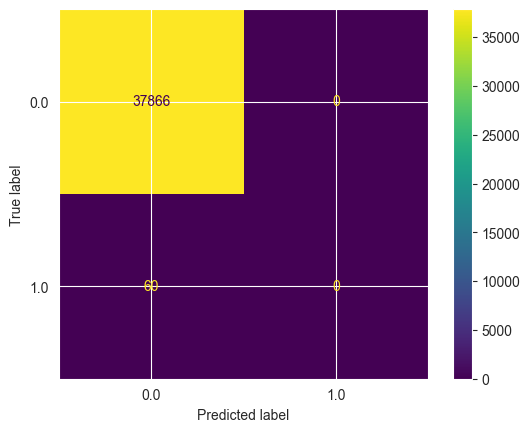

In [138]:
logreg_classifier = LogisticRegression(random_state=0, n_jobs=-1)
logreg_fpr, logreg_tpr, logreg_roc_auc, _ = train_classifier_and_plot(
    logreg_classifier, train_test_pairs
)

### Decision Tree

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37866
         1.0       0.20      0.07      0.10        60

    accuracy                           1.00     37926
   macro avg       0.60      0.53      0.55     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.81


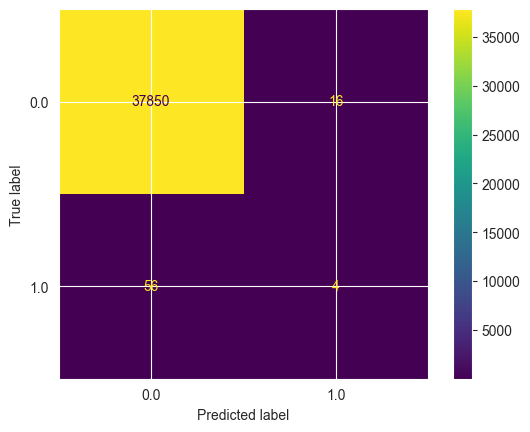

In [139]:
dtree_classifier = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree_fpr, dtree_tpr, dtree_roc_auc, _ = train_classifier_and_plot(
    dtree_classifier,
    train_test_pairs
)

### Random Forest

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37866
         1.0       0.25      0.03      0.06        60

    accuracy                           1.00     37926
   macro avg       0.62      0.52      0.53     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.83


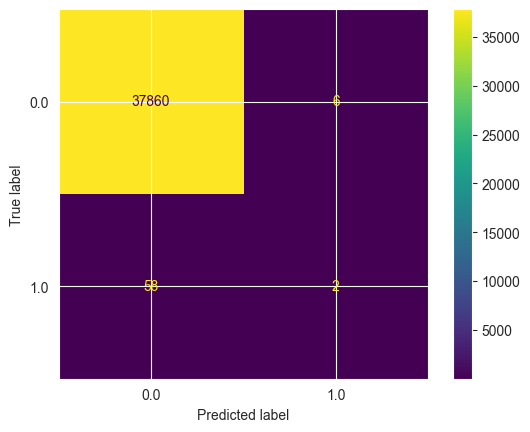

In [140]:
forest_classifier = RandomForestClassifier(random_state=0, n_jobs=-1)
forest_fpr, forest_tpr, forest_roc_auc, _ = train_classifier_and_plot(
    forest_classifier,
    train_test_pairs
)

### ROC curve for the original dataset

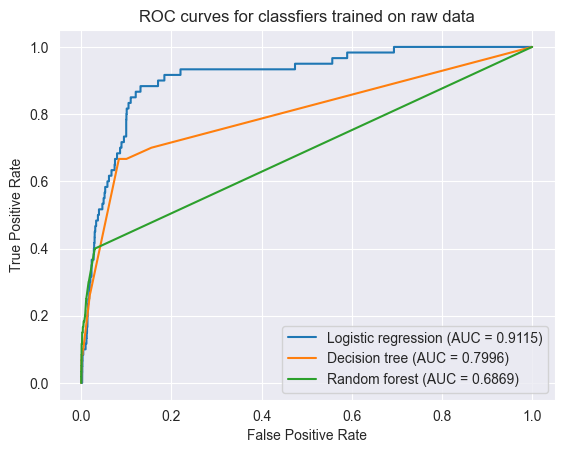

In [141]:
plot_roc_curves(
    "ROC curves for classfiers trained on raw data",
    (logreg_fpr, logreg_tpr, f"Logistic regression (AUC = {logreg_roc_auc:.4f})"),
    (dtree_fpr, dtree_tpr, f"Decision tree (AUC = {dtree_roc_auc:.4f})"),
    (forest_fpr, forest_tpr, f"Random forest (AUC = {forest_roc_auc:.4f})")
)

## Conclusion

As seen in the the training results, the classifiers have managed to get an accuracy score very close to 100% (by about 0.2%). However, this is very misleading to only look at the accuracy statistic as techniques identified very few, if at all, fraudulent transactions as fraudulent. The data has less than 0.04% of fraudulent cases which makes the model bias for viewing almost all transactions as valid.

This shows that we need additional tweaking by adding new data points so that we can improve the true negative case detection.

# Classification task

Pure SMOTE has not performed as well as we would like. In order to improve the recall, we would like to remove Nearest Neighbours of majority and minority class which cause the data to be noisy or boundries to be not very well defined. These are called Tomek Links. A link between point `a` and `b` is a Tomek Link iff:
1. instance `a`’s nearest neighbor is `b`
2. instance `b`’s nearest neighbor is `a`
3. instances `a` and `b` belong to different classes.

In [142]:


# Prepare the data using improved pipeline
pipeline = Pipeline([
    ('custom_transform', CustomDataTransformer(conv, feature_engineering_func=country_equal_feature_eng,
                                               columns_to_scale=['issuercountrycode', 'txvariantcode', 'bin', 'currencycode',
       'shoppercountrycode', 'shopperinteraction',
       'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
       'mail_id', 'ip_id', 'card_id', 'label', 'amount_eur',
       'countries_equal'], scaler = MinMaxScaler())),  # apply the custom function
])
pipeline = pipeline.fit(data_df)
# fit the pipeline to your data and transform it
transformed_data_df = pipeline.transform(data_df)
transformed_train_data_df = transformed_data_df[transformed_data_df['is_train'] == 1].copy()
transformed_train_data_df.drop(['is_train'], axis=1, inplace=True)
transformed_test_data_df = transformed_data_df[transformed_data_df['is_train'] == 0].copy()
transformed_test_data_df.drop(['is_train'], axis=1, inplace=True)
transformed_test_data_df.drop(['label'], axis=1, inplace=True)

In [143]:
def advanced_feature_eng(df):
    """
    Add new aggregate features to the dataframe related to the number of times certain ip/cards/emails have been used.
    :param df: dataframe
    :return: modified dataframe
    """
    # Check if the shopper's country of origin is the same as the issuer country
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    # Check if the shopper's country of origin is the same as the currency
    df['currency_equal'] = (df['shoppercountrycode'] == df['currencycode'])
    df.loc[df['currency_equal'] == False, 'currency_equal'] = 0
    df.loc[df['currency_equal'] == True, 'currency_equal'] = 1

    # Check if the issuer country is the same as the currency
    df['currency_equal_issuer'] = (df['issuercountrycode'] == df['currencycode'])
    df.loc[df['currency_equal_issuer'] == False, 'currency_equal_issuer'] = 0
    df.loc[df['currency_equal_issuer'] == True, 'currency_equal_issuer'] = 1


    # Check how many times an email has been used
    df['email_count'] = df.groupby('mail_id')['mail_id'].transform('count')

    # Check how many times an ip has been used
    df['ip_count'] = df.groupby('ip_id')['ip_id'].transform('count')

    # Check how many times a bin has been used
    df['bin_count'] = df.groupby('bin')['bin'].transform('count')

    # Check i
    return df

# Prepare the data using improved pipeline
pipeline = Pipeline([
    ('custom_transform', CustomDataTransformer(conv, feature_engineering_func=advanced_feature_eng,
                                               columns_to_scale=[ 'amount_eur', 'bin_count', 'ip_count', 'email_count'], scaler = MinMaxScaler(), drop_private_columns=True, one_hot_columns=['txvariantcode','shopperinteraction', 'accountcode'])),  # apply the custom function
])
pipeline = pipeline.fit(data_df)
# fit the pipeline to your data and transform it
transformed_data_df = pipeline.transform(data_df)
transformed_train_data_df = transformed_data_df[transformed_data_df['is_train'] == 1].copy()
transformed_train_data_df.drop(['is_train'], axis=1, inplace=True)
transformed_test_data_df = transformed_data_df[transformed_data_df['is_train'] == 0].copy()
transformed_test_data_df.drop(['is_train'], axis=1, inplace=True)
transformed_test_data_df.drop(['label'], axis=1, inplace=True)

C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [144]:
transformed_test_data_df.head(20)

,cardverificationcodesupplied,cvcresponsecode,amount_eur,countries_equal,currency_equal,currency_equal_issuer,email_count,ip_count,bin_count,txvariantcode_electron,...,txvariantcode_visaplatinum,txvariantcode_visapurchasing,txvariantcode_visasignature,shopperinteraction_ContAuth,shopperinteraction_Ecommerce,shopperinteraction_POS,accountcode_APAC,accountcode_GB,accountcode_MX,accountcode_SE
0,0,1,0.003569,1,1,1,0.000000,0.000000,1.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,1,1,0.017974,1,1,1,0.000000,0.000000,0.035922,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,1,1,0.058493,1,1,1,0.000000,0.000000,0.026660,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,1,0,0.026248,1,1,1,0.000000,0.000000,0.014223,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
16,1,0,0.020779,1,1,1,0.000000,0.000000,0.013165,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
26,1,1,0.017472,1,1,1,0.005935,0.002146,0.353136,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
27,1,1,0.021135,1,1,1,0.000000,0.000000,0.092154,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
42,1,0,0.019311,1,1,1,0.000000,0.000000,0.050476,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
43,1,0,0.008123,1,1,1,0.000000,0.000000,0.307158,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
46,1,1,0.051935,1,1,1,0.000000,0.000000,0.050675,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [145]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

X = transformed_train_data_df.drop(['label'], axis=1)
y = transformed_train_data_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

before_smote_valid = len(y_train[y_train == 0])
before_smote_fraud = len(y_train[y_train == 1])

smote = SMOTE(sampling_strategy='minority', random_state=0)
tomek = TomekLinks(n_jobs=-1)
smote_tomek = SMOTETomek(smote=smote, tomek=tomek, random_state=0, n_jobs=-1)

X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

train_test_pairs = (X_train, X_test, y_train, y_test)

after_smote_valid = len(y_train[y_train == 0])
after_smote_fraud = len(y_train[y_train == 1])

results_smote_matrix = pd.DataFrame([
    ["before", before_smote_valid, before_smote_fraud],
    ["after", after_smote_valid, after_smote_fraud]],
    columns=["SMOTE", "valid", "fraud"])
results_smote_matrix.set_index('SMOTE', inplace=True)
results_smote_matrix

,valid,fraud
SMOTE,,
before,151490,212
after,151490,151198


In [146]:
# Show the dataframe
X_train.head()

,cardverificationcodesupplied,cvcresponsecode,amount_eur,countries_equal,currency_equal,currency_equal_issuer,email_count,ip_count,bin_count,txvariantcode_electron,...,txvariantcode_visaplatinum,txvariantcode_visapurchasing,txvariantcode_visasignature,shopperinteraction_ContAuth,shopperinteraction_Ecommerce,shopperinteraction_POS,accountcode_APAC,accountcode_GB,accountcode_MX,accountcode_SE
0,1,1,0.019630,1.0,1.0,1.0,0.0,0.004292,0.247817,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,1,0.016953,1.0,1.0,1.0,0.0,0.000000,0.070257,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,1,0.007250,1.0,1.0,1.0,0.0,0.000000,0.067875,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,0,0.047130,1.0,1.0,1.0,0.0,0.000000,0.021103,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1,1,0.016953,1.0,1.0,1.0,0.0,0.000000,0.370601,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Training a Whitebox classifier - Decision Tree

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37862
         1.0       1.00      0.09      0.17        64

    accuracy                           1.00     37926
   macro avg       1.00      0.55      0.59     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.85


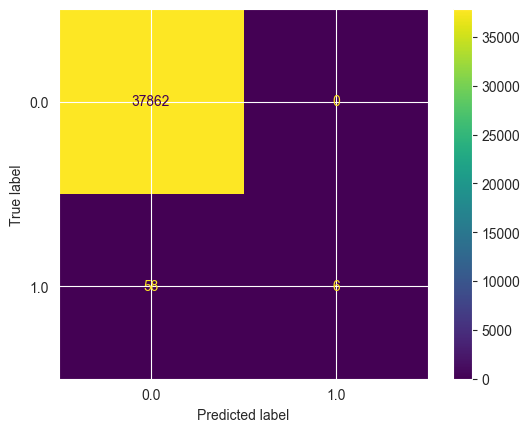

In [147]:
from sklearn.model_selection import KFold, cross_validate


def k_fold_cross_validation(X_data_train, y_data_train, model, scoring, k=10):
    cv = KFold(n_splits=k, random_state=0, shuffle=True)
    res = cross_validate(model, X_data_train, y_data_train, scoring=scoring, return_estimator=True, cv=cv, n_jobs=-1)
    best_index = np.argmax(res['test_score'])
    model = res['estimator'][best_index]
    return model


dtree_classifier = DecisionTreeClassifier(max_depth=7, criterion='entropy')
dtree_fpr, dtree_tpr, dtree_roc_auc, dtree_classifier = train_classifier_and_plot(
    dtree_classifier,
    train_test_pairs,
    cv_func=k_fold_cross_validation
)



### Training a Whitebox classifier - Decision Tree
We used decision tree as a Whitebox classifier with entropy as the criterion and max_depth=7. We used 10-fold cross-validation to find the best model. We made this decision because it is very easy to interpret its decision, as depicted below. The depth was limited to 7 so that the tree does not overfit to the data too much and the nodes are clearly visible. From the graph, we can see that in the beginning, the tree makes decision based on very general features such as amount of money and the cvr response code. Then, it starts being more specific by looking at features such as card_id and ip_id, probably under the assumption that fraud tends to be committed more than once from a single account which might eventually lead to overfitting if we allow the tree to grow deeper.

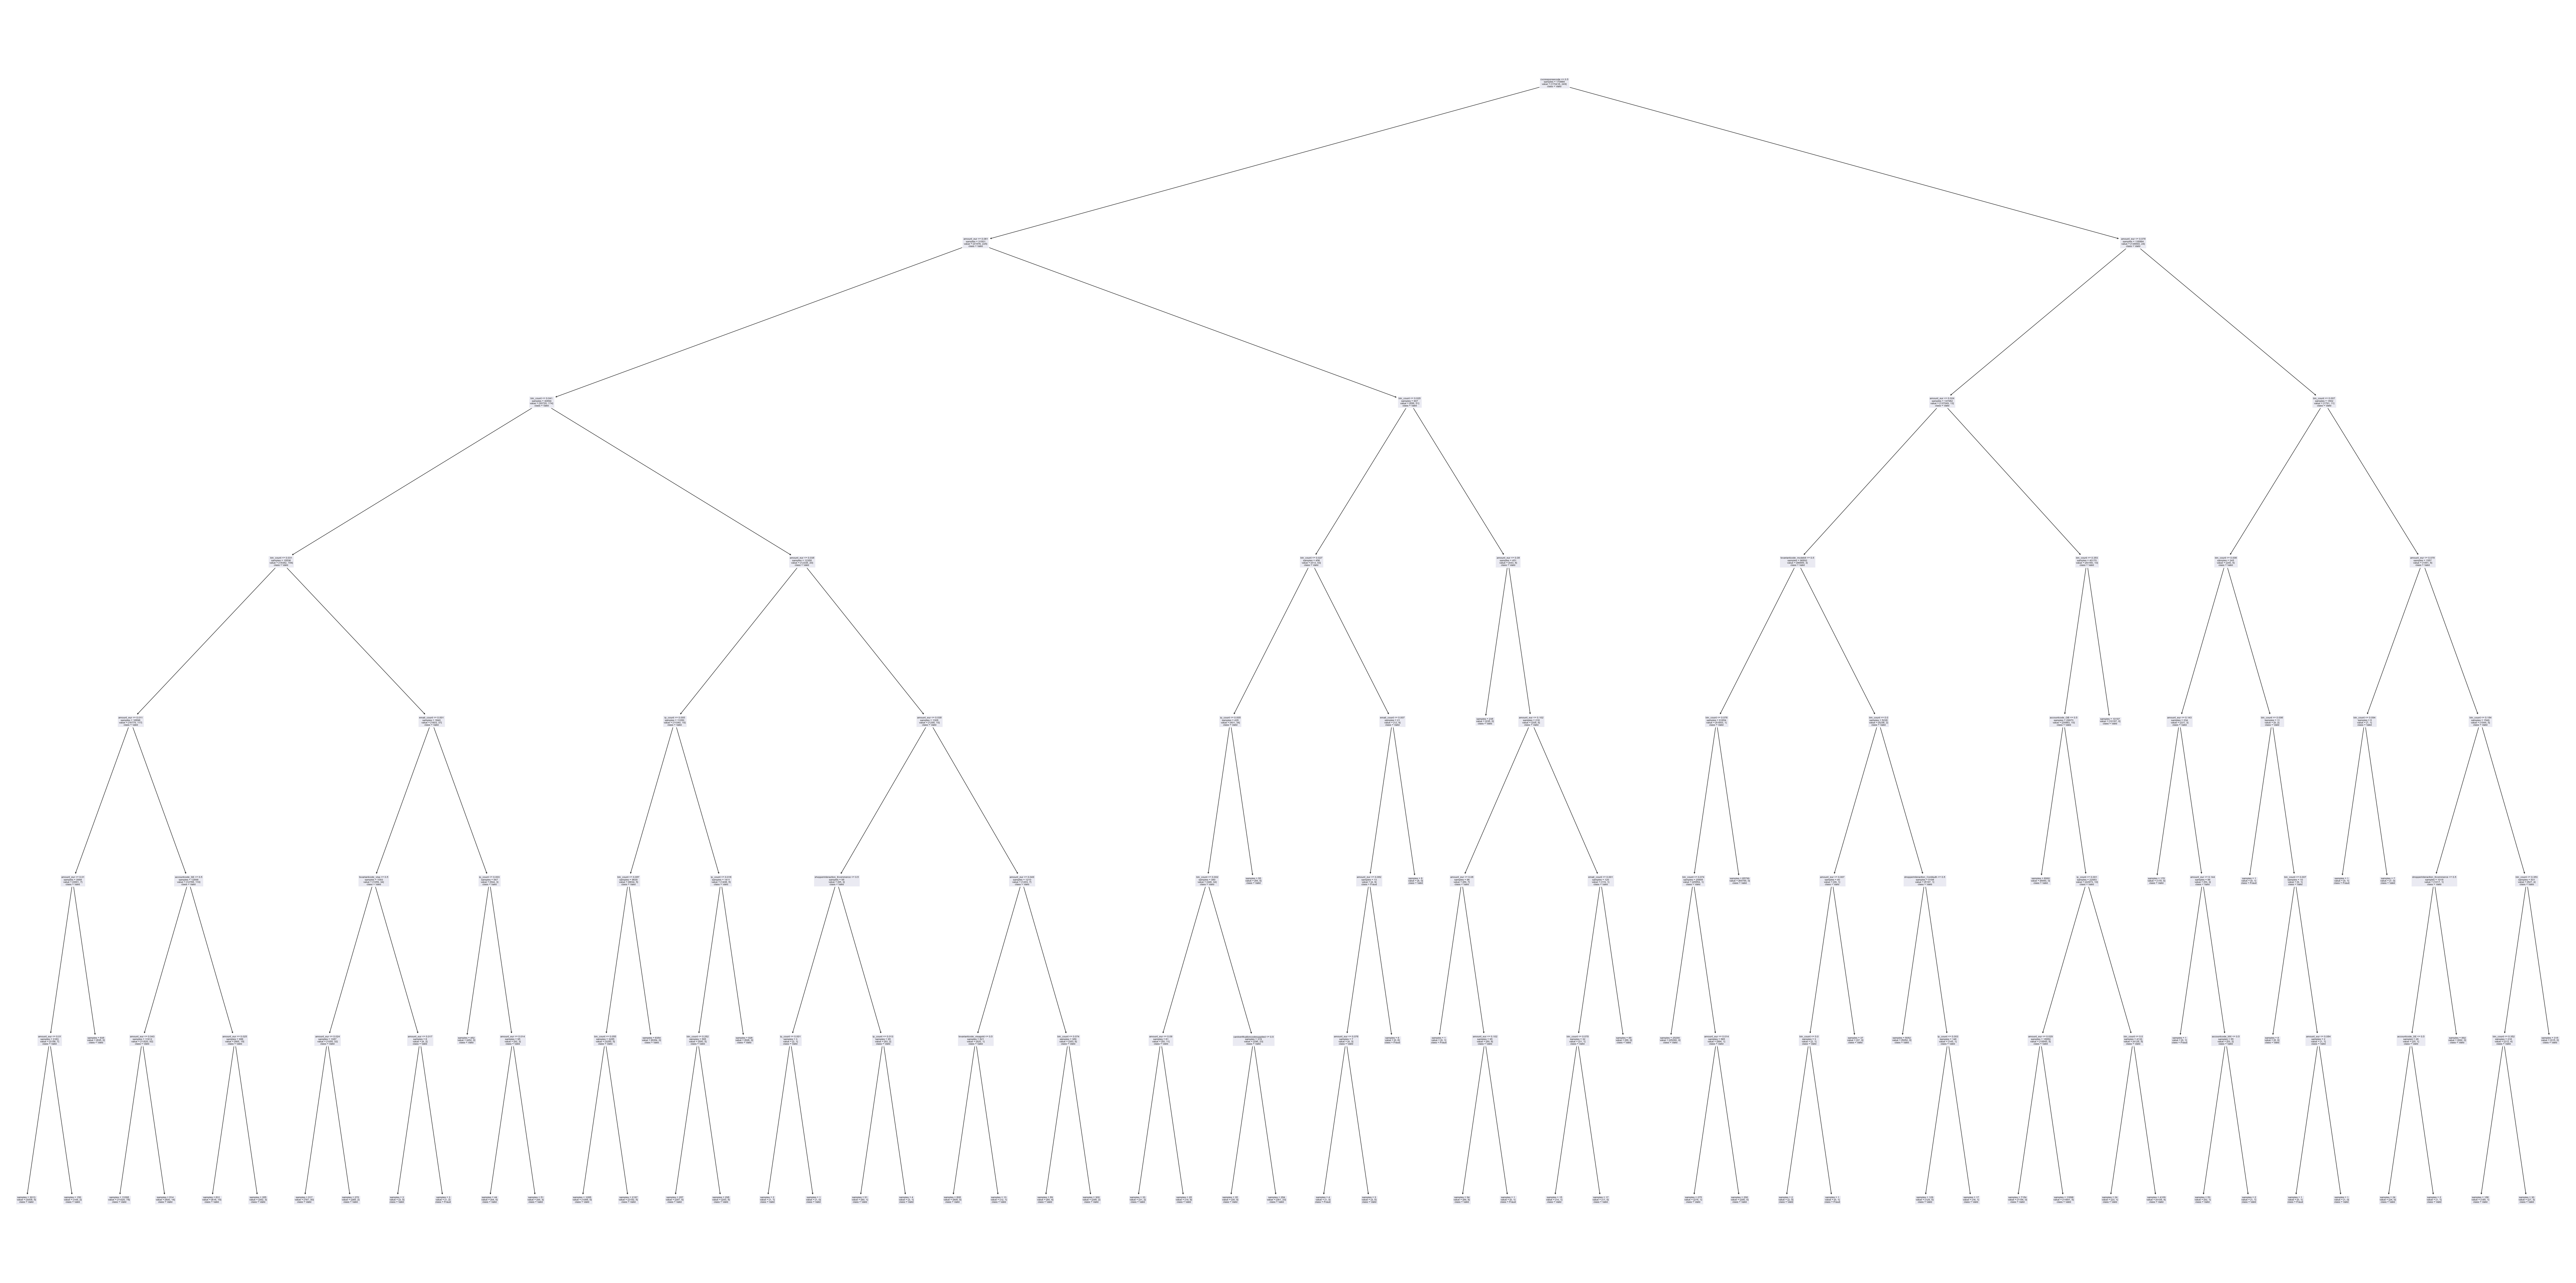

In [148]:
from sklearn.tree import plot_tree

plt.figure(figsize=(100,50))
plot_tree(dtree_classifier, feature_names=X_train.columns, class_names=['Valid', 'Fraud'], impurity=False)
plt.show()

### Training a Blackbox classifier - Random Forest

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37862
         1.0       0.96      0.80      0.87        64

    accuracy                           1.00     37926
   macro avg       0.98      0.90      0.94     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.96


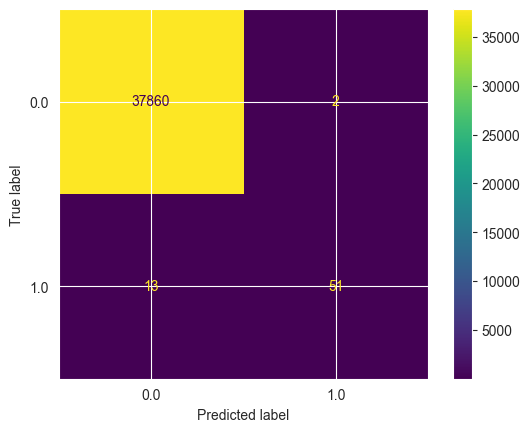

[7.01830180e-03 1.31188020e-02 5.01238659e-01 2.11334903e-03
 2.05758611e-03 2.13594143e-03 4.10184729e-02 4.73069408e-02
 3.14993997e-01 3.13863332e-06 7.25633342e-10 1.05473858e-02
 5.23422613e-03 3.92770639e-03 1.20436132e-04 4.69424342e-03
 2.56437246e-05 1.01878900e-02 2.52105869e-03 3.47311081e-03
 1.06331281e-07 4.31637898e-05 1.77564064e-03 2.21757756e-03
 2.56805968e-05 7.18641624e-03 7.35509640e-03 4.90246151e-03
 4.75696621e-03]


Index(['cardverificationcodesupplied', 'cvcresponsecode', 'amount_eur',
       'countries_equal', 'currency_equal', 'currency_equal_issuer',
       'email_count', 'ip_count', 'bin_count', 'txvariantcode_electron',
       'txvariantcode_mc', 'txvariantcode_mccredit', 'txvariantcode_mcdebit',
       'txvariantcode_visa', 'txvariantcode_visabusiness',
       'txvariantcode_visaclassic', 'txvariantcode_visacorporate',
       'txvariantcode_visadebit', 'txvariantcode_visagold',
       'txvariantcode_visaplatinum', 'txvariantcode_visapurchasing',
       'txvariantcode_visasignature', 'shopperinteraction_ContAuth',
       'shopperinteraction_Ecommerce', 'shopperinteraction_POS',
       'accountcode_APAC', 'accountcode_GB', 'accountcode_MX',
       'accountcode_SE'],
      dtype='object')

In [149]:
# Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()
forest_fpr, forest_tpr, forest_roc_auc, random_forest_classifier = train_classifier_and_plot(
    random_forest_classifier,
    train_test_pairs,
    cv_func=k_fold_cross_validation
)
# Feature importance
print(random_forest_classifier.feature_importances_)
train_test_pairs[0].columns

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37862
         1.0       0.91      0.81      0.86        64

    accuracy                           1.00     37926
   macro avg       0.96      0.91      0.93     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.96


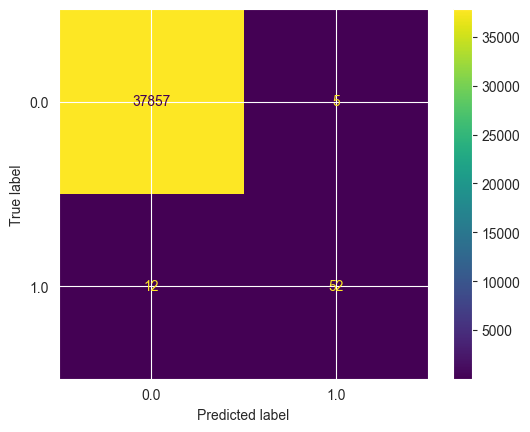

In [150]:
# Knn classifier

from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn_fpr, knn_tpr, knn_roc_auc, knn_classifier = train_classifier_and_plot(
    knn_classifier,
    train_test_pairs,
    cv_func=k_fold_cross_validation
)

### Differences
As seen in the results, the Random Forest classifier has a higher AUC score than the Decision Tree classifier. This is because the Random Forest classifier is an ensemble of decision trees, which means that it is more robust to overfitting and can generalize better to unseen data. Moreover, judging from the F1-score and recall (which were chosen because of how good they are at capturing false negatives), the Random Forest is much better at classifying frauds than the Decision Tree classifier. One limiting factor that contributed to the relatively poor performance of the decision tree is its limited depth. While it fights overfitting, it also reduces the capacity of the model to learn more complex patterns in the data. This is where the Random Forest classifier shines, as it is able to learn more complex patterns by combining multiple decision trees.

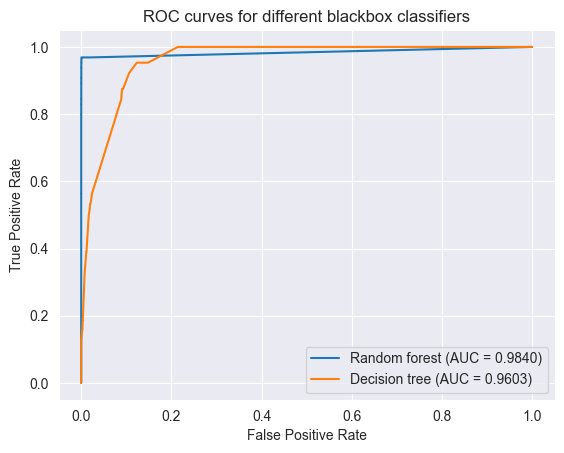

In [151]:
plot_roc_curves("ROC curves for different blackbox classifiers",
                (forest_fpr, forest_tpr, f"Random forest (AUC = {forest_roc_auc:.4f})"),
                (dtree_fpr, dtree_tpr, f"Decision tree (AUC = {dtree_roc_auc:.4f})")
)

### Aggregate features
The following function can be added to the pipeline to add aggregate features to the dataset. However, due to the type of smoting we use, it is not possible to use it in the current pipeline as the code takes too long to run.

In [152]:
def advanced_feature_eng(df):
    """
    Add new aggregate features to the dataframe related to the number of times certain ip/cards/emails have been used.
    :param df: dataframe
    :return: modified dataframe
    """
    # Check if the shopper's country of origin is the same as the issuer country
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    # Check if the shopper's country of origin is the same as the currency
    df['currency_equal'] = (df['shoppercountrycode'] == df['currencycode'])
    df.loc[df['currency_equal'] == False, 'currency_equal'] = 0
    df.loc[df['currency_equal'] == True, 'currency_equal'] = 1

    # Check how many times an email has been used
    df['email_count'] = df.groupby('mail_id')['mail_id'].transform('count')

    # Check how many times an ip has been used
    df['ip_count'] = df.groupby('ip_id')['ip_id'].transform('count')

    # Check how many times a bin has been used
    df['bin_count'] = df.groupby('bin')['bin'].transform('count')

    return df

### Kaggle submission

In [153]:
test_pred = knn_classifier.predict(transformed_test_data_df)

answers_df = pd.DataFrame(test_pred, columns=['Predicted'])
answers_df['Id'] = transformed_test_data_df.index
# Drop index of answers_df
answers_df = answers_df.set_index('Id')
answers_df.to_csv('answers2.csv')
# Print first 20 rows
print(answers_df.head(20))

    Predicted
Id           
0         0.0
5         0.0
7         0.0
9         0.0
16        0.0
26        0.0
27        0.0
42        0.0
43        0.0
46        0.0
48        0.0
49        0.0
52        0.0
55        0.0
60        0.0
75        0.0
80        0.0
82        0.0
90        0.0
96        0.0


In [154]:
print(sum(answers_df['Predicted']))

62.0


In [155]:
test_pred = random_forest_classifier.predict(transformed_test_data_df)

answers_df = pd.DataFrame(test_pred, columns=['Predicted'])
answers_df['Id'] = transformed_test_data_df.index
# Drop index of answers_df
answers_df = answers_df.set_index('Id')
answers_df.to_csv('answers.csv')
# Print first 20 rows
print(answers_df.head(20))
print(sum(answers_df['Predicted']))

    Predicted
Id           
0         0.0
5         0.0
7         0.0
9         0.0
16        0.0
26        0.0
27        0.0
42        0.0
43        0.0
46        0.0
48        0.0
49        0.0
52        0.0
55        0.0
60        0.0
75        0.0
80        0.0
82        0.0
90        0.0
96        0.0
11.0


In [156]:
# List columns of the dataframe
print(transformed_train_data_df.columns)


Index(['cardverificationcodesupplied', 'cvcresponsecode', 'label',
       'amount_eur', 'countries_equal', 'currency_equal',
       'currency_equal_issuer', 'email_count', 'ip_count', 'bin_count',
       'txvariantcode_electron', 'txvariantcode_mc', 'txvariantcode_mccredit',
       'txvariantcode_mcdebit', 'txvariantcode_visa',
       'txvariantcode_visabusiness', 'txvariantcode_visaclassic',
       'txvariantcode_visacorporate', 'txvariantcode_visadebit',
       'txvariantcode_visagold', 'txvariantcode_visaplatinum',
       'txvariantcode_visapurchasing', 'txvariantcode_visasignature',
       'shopperinteraction_ContAuth', 'shopperinteraction_Ecommerce',
       'shopperinteraction_POS', 'accountcode_APAC', 'accountcode_GB',
       'accountcode_MX', 'accountcode_SE'],
      dtype='object')


AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'